# Classifying newswires: a multi-class classification example
---- 

Here, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification".

## The Reuters dataset

We will be working with ```Reuters dataset```, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.

In [1]:
# Load packages
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import reuters

tf.__version__

'1.13.1'

In [2]:
# Load data
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [3]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(8982,) (8982,)
(2246,) (2246,)


In [4]:
# Get word-index mapping
word_index = reuters.get_word_index()

# reverse mapping to get index-word mapping
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

### Decode encoded reviews back to original

In [5]:
# Get the real news data using reverse index
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [6]:
# Vectorize sequences
def vectorize_sequences(sequences, dimension=10000):
    # numpy zero-matrix to hold vectors
    results = np.zeros((len(sequences), dimension))
    # Iterate over the sequence
    for i, sequence in enumerate(sequences):
        # Assign value at index
        results[i, sequence] = 1.
    return results

# Apply to train data
x_train = vectorize_sequences(train_data)

# Apply to test data
x_test = vectorize_sequences(test_data)

In [7]:
print(x_train[0], x_train[1])

print(x_test[0], x_test[1])

[0. 1. 1. ... 0. 0. 0.] [0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.] [0. 1. 1. ... 0. 0. 0.]


In [8]:
# Create one-hot vectors for the labels
def to_one_hot(labels, dimension=46):
    # Zero matrix t hold one-hot vectors
    results = np.zeros((len(labels), dimension))
    # Iterate through the labels
    for i, label in enumerate(labels):
        # Assign true at index
        results[i, label] = 1.
    return results

# Apply to train labels
one_hot_train_labels = to_one_hot(train_labels)

# Apply to test labels
one_hot_test_labels = to_one_hot(test_labels)

In [9]:
one_hot_train_labels[0], one_hot_test_labels[0]

(array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

**You can do the same using the built-in method.**

In [10]:
# Load packages
from tensorflow.keras.utils import to_categorical

In [11]:
# Create one-hot vectors
one_hot_train_labels = to_categorical(train_labels)

one_hot_test_labels = to_categorical(test_labels)

print(one_hot_train_labels[0], one_hot_test_labels[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
# Split train data for validation
x_val, x_train = x_train[:1000], x_train[1000: ]

y_val, y_train = one_hot_train_labels[:1000], one_hot_train_labels[1000:]

print(x_val.shape, y_val.shape)

print(x_train.shape, y_train.shape)

(1000, 10000) (1000, 46)
(7982, 10000) (7982, 46)


### Model

In [13]:
def mlp_model(depth, num_classes):
    # Initiate a sequencial model
    model = tf.keras.models.Sequential([
        # Input layer
        tf.keras.layers.Dense(depth, activation="relu", input_shape=(10000,)),
        # Hidden layer
        tf.keras.layers.Dense(depth*2, activation="relu"),
        # Output layer
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])
    # Compile model
    model.compile(optimizer="rmsprop",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [14]:
# Train model and validate after each epoch
model = mlp_model(depth=32, num_classes=46)

history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(x_val, y_val))

Instructions for updating:
Colocations handled automatically by placer.
Train on 7982 samples, validate on 1000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
7982/7982 [==============================] - 2s 305us/sample - loss: 2.5122 - acc: 0.4857 - val_loss: 1.6953 - val_acc: 0.6350
Epoch 2/10
7982/7982 [==============================] - 2s 209us/sample - loss: 1.4338 - acc: 0.6939 - val_loss: 1.3252 - val_acc: 0.7070
Epoch 3/10
7982/7982 [==============================] - 2s 221us/sample - loss: 1.1013 - acc: 0.7655 - val_loss: 1.1544 - val_acc: 0.7460
Epoch 4/10
7982/7982 [==============================] - 2s 244us/sample - loss: 0.8792 - acc: 0.8146 - val_loss: 1.0888 - val_acc: 0.7560
Epoch 5/10
7982/7982 [==============================] - 2s 212us/sample - loss: 0.7056 - acc: 0.8469 - val_loss: 0.9819 - val_acc: 0.8030
Epoch 6/10
7982/7982 [==============================] - 2s 218us/sample - loss: 0.5659 - acc: 0.8758 - val_loss: 0.9266 - val_acc: 0.8080
Epoc

### Performance visualization

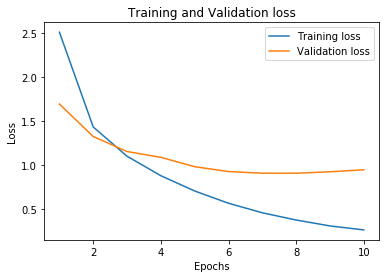

In [15]:
# Plot train loss vs validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# get epochs
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "-", label="Training loss")
plt.plot(epochs, val_loss, "-", label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

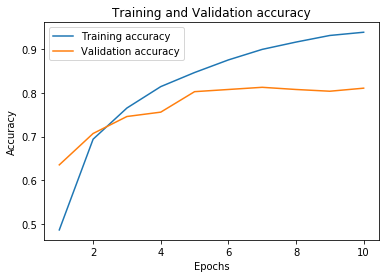

In [16]:
# Plot train accuracy vs Validation accuracy
acc = history.history["acc"]
val_acc = history.history["val_acc"]

plt.plot(epochs, acc, "-", label="Training accuracy")
plt.plot(epochs, val_acc, "-", label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [17]:
# evaluate on test set
results = model.evaluate(x_test, one_hot_test_labels)
"loss = {}, and accuracy = {}".format(results[0], results[1])

2246/2246 [==============================] - 0s 115us/sample - loss: 1.0218 - acc: 0.7836


'loss = 1.0217893153349418, and accuracy = 0.7836152911186218'

**Our approach reaches an accuracy of ~78+%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%, so our results seem pretty good, at least when compared to a random baseline.**